In [1]:
#export
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from skimage import io
import PIL,os,mimetypes

In [3]:
#export
Path.ls = lambda x: list(x.iterdir())

In [4]:
#export
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [5]:
#export
class ImageSlicer():
    
    def __init__(self, source, _slice_size = 700, resize= (448,448), overlap = 5, PADDING=True):
        self.source = source
        self._slice_size = _slice_size
        self.resize = resize
        self.overlap = overlap
        self.PADDING = PADDING
        
    def _read_images(self):
        Images = []
        image_names = sorted(os.listdir(self.source))
        for im in image_names:
            image = plt.imread(os.path.join(dir_path,im))
            Images.append(image)
        return Images

    def _offset_op(self, input_length, output_length, strides):
        
        offset = (input_length) - (strides[0]*((input_length - output_length)//strides[0])+output_length)
        return offset
    
    def _padding_op(self, Image, strides):
        if self.offset_x > 0:
            padding_x = strides - self.offset_x
        else:
            padding_x = 0
        if self.offset_y > 0:
            padding_y = strides - self.offset_y
            
        else:
            padding_y = 0
        Padded_Image = np.zeros(shape=(Image.shape[0]+padding_x, Image.shape[1]+padding_y, Image.shape[2]),dtype=Image.dtype)
        Padded_Image[padding_x//2:(padding_x//2)+(Image.shape[0]),padding_y//2:(padding_y//2)+Image.shape[1],:] = Image    
        return Padded_Image

    def _convolution_op(self, Image, strides):
        start_x = 0
        start_y = 0
        n_rows = Image.shape[0]//strides[0] + 1
        n_columns = Image.shape[1]//strides[1] + 1
        small_images = []
        for i in range(n_rows-1):
            for j in range(n_columns-1):
                new_start_x = start_x+i*strides[0]
                new_start_y= start_y+j*strides[1]
                small_images.append(Image[new_start_x:new_start_x+self._slice_size,new_start_y:new_start_y+self._slice_size,:])
        return small_images

    def _transform(self):
        
        if not(os.path.exists(self.source)):
            raise Exception("Path does not exist!")
            
        else:
            if self.source:
                Image = plt.imread(self.source)
                Images = [Image]
            else: 
                Images = self.__read_images()

            im_size = Images[0].shape
            num_images = len(Images)
            transformed_images = dict()
            Images = np.array(Images)
            
            stride_x = []
            stride_y = []

            if self.overlap == None:
                stride_x = self_slice_size
                stride_y = self._slice_size
            elif self.overlap == 0 or self.overlap == 1:
                stride_x = self_slice_size
                stride_y = self._slice_size
            elif self.overlap > 1:
                stride_x = self._slice_size/self.overlap*(self.overlap-1)
                stride_x = int(stride_x)
                stride_y = self._slice_size/self.overlap*(self.overlap-1)
                stride_y = int(stride_x)

            strides = [stride_x, stride_y]
            
            if self.PADDING:
                
                padded_images = []

                if  strides == None:
                    strides = self._slice_size
                    strides = self._slice_size
                    self.offset_x = Images.shape[1]%self._slice_size
                    self.offset_y = Images.shape[2]%self._slice_size
                    padded_images = list(map(self._padding_op, Images))
                                        
                elif strides==None and strides!=None:   
                    strides = self._slice_size
                    self.offset_x = Images.shape[1]%self._slice_size
                    padded_images = list(map(self._padding_op, Images))

                elif strides!=None and strides==None:   
                    strides = self._slice_size
                    self.offset_y = Images.shape[2]%self._slice_size
                    padded_images = list(map(self._padding_op, Images))
                                         
                else:
                    self.offset_x = self._offset_op(Images.shape[1], self._slice_size, strides)
                    self.offset_y = self._offset_op(Images.shape[2], self._slice_size, strides)
                    padded_images = list(map(self._padding_op, Images, strides))

                for i, Image in enumerate(padded_images):
                    transformed_images[str(i)] = self._convolution_op(Image, strides)

            else:
                if strides==None and strides==None:
                    strides = self._slice_size
                    strides = self._slice_size

                elif strides==None and strides!=None:               
                    strides = self._slice_size

                elif strides!=None and strides==None:        
                    strides = self._slice_size
                else:                                         
                    for i, Image in enumerate(Images):
                        transformed_images[str(i)] = self._convolution_op(Image)

            return transformed_images
        
    def quantile_from_slice_range(slice_range):
        _slice_size_0 = int(slice_range[0])
        _slice_size_1 = int(np.percentile(slice_range, 25, axis=0))
        _slice_size_2 = int(np.percentile(slice_range, 50, axis=0))
        _slice_size_3 = int(np.percentile(slice_range, 75, axis=0))
        _slice_size_4 = int(slice_range[1])

        slice_l = [_slice_size_0,_slice_size_1 , _slice_size_2 ,  _slice_size_3 , _slice_size_4 ]
        return slice_l

    def show_slices(slice_l, inp_d , pos= None):
        
        if pos == None:
            pos = 0
        
        inp_d = Path(inp_d)
                    
        sl = [o.name for o in os.scandir(inp_d)]
        sl = ImageSlicer._get_files(inp_d, sl)
        im = Image.open(sl[pos])
        
        cropped_l = []
        for i in slice_l:
            left, top, right, bottom = 0, 0, i, i
            c  = im.crop( ( left, top, right, bottom ) )
            cropped_l.append(c) 
            

        Tot = number_of_subplots=len(slice_l)
        Tot = Tot +1
        Cols = 2
        Rows = Tot // Cols 
        Rows += Tot % Cols
        Position = range(1,Tot)

        fig = plt.figure(figsize=(12,12))


        for j, k in enumerate(cropped_l):
            ax = fig.add_subplot(Rows,Cols,Position[j])
            ax.imshow(k,interpolation='lanczos' )     
            ax.set_axis_off()
            ax.set_title(f'Slice size: {slice_l[j]}')
        plt.show()

    def _get_files(p, fs, extensions=image_extensions):
        p = Path(p)
        res = [p/f for f in fs if not f.startswith('.')
               and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
        return res


    def slice_images(inp_d, dir_name , slice_l , resize, overlap , out_path= None, cb=None):
                    
        inp_d = Path(inp_d)
        if out_path==None:
                    out_path = inp_d
        out_path = Path(inp_d)
                    
        im_l = [o.name for o in os.scandir(inp_d)]
        im_l = ImageSlicer._get_files(inp_d, im_l)

        cb = PrintStatusCallback()

        for i in slice_l:
            last_slice = slice_l[-1]

            if cb: cb.before_calc(i)
            for im in im_l:
                slicer = ImageSlicer(im, _slice_size = i ,overlap=overlap) 
                transformed_image = slicer._transform()
                ImageSlicer._save_images(transformed=transformed_image,resize=resize , out_path=out_path , dir_name=dir_name, _slice_size=i , overlap = overlap, im = im)
            if cb: cb.after_calc(i, last_slice, out_path/dir_name) 
                    
    def _save_images(transformed, out_path, dir_name, resize, _slice_size=int , overlap =int ,im = None):
        
        if type(resize) == tuple:
            resize_t = resize
        else:
            resize_t = ()
            resize_t = (resize , resize)
                    
        (out_path/dir_name).mkdir(exist_ok=True)
        for key, val in transformed.items():
            for k, j in enumerate(val):
                img = Image.fromarray(j, 'RGB') 
                diff = _slice_size - resize_t[0]
                diff_h = diff//2 + resize_t[0]
                
                img.resize((diff_h, diff_h),resample=Image.BICUBIC).resize(resize_t, resample= PIL.Image.NEAREST).save(out_path/dir_name/f'{im.stem}_{k}_{overlap}_{_slice_size}.png')


    def slice_masks(inp_d , dir_name  ,slice_l ,resize, overlap , out_path=None, cb=None, palette = None):
                    
        inp_d = Path(inp_d)
        if out_path==None:
                    out_path = inp_d
        out_path = Path(inp_d)

        mask_l = [o.name for o in os.scandir(inp_d)]
        mask_l = ImageSlicer._get_files(inp_d, mask_l)

        cb = PrintStatusCallback()

        for i in slice_l:
            last_slice = slice_l[-1]

            if cb: cb.before_calc(i)
            for im in mask_l:
                slicer = ImageSlicer(im, _slice_size = i ,overlap=overlap) 
                transformed_image = slicer._transform()
                ImageSlicer._save_masks(transformed=transformed_image,resize=resize , out_path=out_path , dir_name=dir_name, _slice_size=i , overlap = overlap, im = im)
            if cb: cb.after_calc(i, last_slice, out_path/dir_name )    
        
        if palette != None:
                    print("----")
                    print("Convert colour to grey")
                    
                    mask_grey_l = [o.name for o in os.scandir(inp_d/dir_name)]
                    mask_grey_l = ImageSlicer._get_files(inp_d/dir_name, mask_grey_l)
            
                    for mask in mask_grey_l:
                        mask_r = io.imread(mask) 
                        mask_c = ImageSlicer._color_to_grey(mask_rgb = mask_r , palette = palette, out_path =out_path/dir_name/dir_name,dir_name = dir_name , path=mask)
                    
                    print(cb.after_calc(i,last_slice ,out_path/dir_name/dir_name ))
                    
    
    def _save_masks(transformed, out_path, dir_name, resize, _slice_size=None , overlap =int,im = None): 
                    
        if type(resize) == tuple:
            resize_t = resize
        else:
            resize_t = ()
            resize_t = (resize , resize)
                    
        (out_path/dir_name).mkdir(exist_ok=True)
        for key, val in transformed.items():
            for k, j in enumerate(val):
                img = Image.fromarray(j, 'RGB') 
                img.resize(resize_t,resample=Image.NEAREST).save(out_path/dir_name/f'{im.stem}_{k}__{overlap}_{_slice_size}.png')
    
    def _color_to_grey(mask_rgb, palette=None, out_path=None, dir_name=None , path=None):
        """ RGB-color encoding to grayscale labels """
        if palette == None:
            raise Exception("Please insert palette")
        else:
            (out_path).mkdir(exist_ok=True)
            invert_palette = {v: k for k, v in palette.items()}
            mask_g = np.zeros((mask_rgb.shape[0], mask_rgb.shape[1]), dtype=np.uint8)
            for c, i in invert_palette.items():
                m = np.all(mask_rgb == np.array(c).reshape(1, 1, 3), axis=2)
                mask_g[m] = i
                break

            mask_a = Image.fromarray(mask_g, 'L') 
            mask_a.save(out_path/f'{path.stem}.png')

class PrintStatusCallback():
    def __init__(self): pass
    def before_calc(self, slice_s, **kwargs): print(f"Process slice: {slice_s}") 
    def after_calc (self, slice_s, last_slice,out_path, **kwargs): 
        if last_slice != None:
            print(f"Finished")
        print("----")
        if slice_s == last_slice:
            print(f'Saved under: {out_path}')  
            print('Count: ' , len(list(out_path.glob('*.png'))))

## Parameter

In [6]:
slice_range = [500, 900]
slice_l = ImageSlicer.quantile_from_slice_range(slice_range);slice_l

[500, 600, 700, 800, 900]

In [7]:
resize = 448
overlap = 7
dir_name = f'diff3_{resize}_{overlap}_{slice_range[0]}-{slice_range[1]}'; dir_name

'diff3_448_7_500-900'

In [8]:
palette = {0 : (255, 255, 255), # Undurchlässige Oberfläche (Weiß)
           1 : (0, 0, 255),     # Gebäude (Blau)
           2 : (0, 255, 255),   # niedrige Vegetation (Cyan)
           3 : (0, 255, 0),     # Baum (grün)
           4 : (255, 255, 0),   # Auto (gelb)
           5 : (255, 0, 0),     # Unordnung (red)
           6 : (0, 0, 0)}       # Schwarz (Schwarz)

In [9]:
inp_d = Path("/Users/Abalone/Desktop/Test_vahingen/Vaihingen")

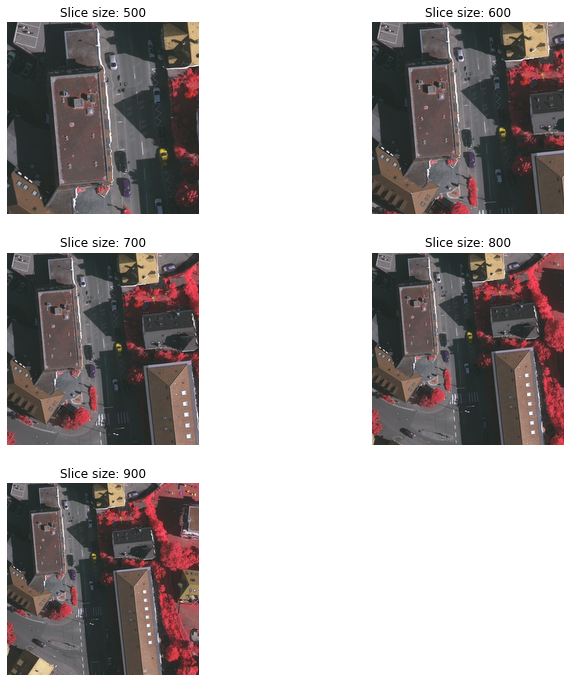

In [10]:
ImageSlicer.show_slices(slice_l, inp_d)

## Train

In [11]:
inp_d = Path("/Users/Abalone/Desktop/Test_vahingen/Vaihingen")

In [12]:
ImageSlicer.slice_images(inp_d= inp_d, dir_name = dir_name, slice_l = slice_l ,resize=resize, overlap = overlap)

Process slice: 500
Finished
----
Process slice: 600
Finished
----
Process slice: 700
Finished
----
Process slice: 800
Finished
----
Process slice: 900
Finished
----
Saved under: /Users/Abalone/Desktop/Test_vahingen/Vaihingen/diff3_448_7_500-900
Count:  200


## Valid

In [ ]:
inp_d = Path("/Users/Abalone/Desktop/Test_vahingen/Vaihingen")

In [ ]:
ImageSlicer.slice_images(inp_d= inp_d, slice_l = slice_l ,resize=resize, overlap = overlap)

## Mask colour

In [15]:
inp_d2 = Path("/Users/Abalone/Desktop/Test_vahingen/vaihingen_mask")

In [ ]:
ImageSlicer.slice_masks(inp_d= inp_d2, dir_name = dir_name, resize = resize , slice_l = slice_l ,overlap = overlap , palette = palette)

Process slice: 500
Finished
----
Process slice: 600


In [ ]:
ImageSlicer.slice_maks(inp_d= inp_d2, dir_name = dir_name, slice_l = slice_l ,overlap = overlap , palette = palette)

## Export

In [ ]:
!python notebook2script.py Image_slicer_scale.ipynb